In [1]:
using Distributions
using KernelDensity
using LinearAlgebra
using Optim
using QuadGK
using Random
using Roots
using StatsPlots
default(fmt=:png)
using BenchmarkTools: @btime, @benchmark

simpson_diversity_index(p) = 1 - dot(p, p)

function sidhat_naive(K)
    n = sum(K)
    1 - sum(k*(k-1)/(n*(n-1)) for k in K)
end

function sidhat(K)
    n = sum(K)
    1 - (dot(K, K) - n)/(n*(n-1))
end

sid_bayes_naive(P, n) = 1 - sum(p^2 - 2p*(1-p)/(n-1) for p in P)
sid_bayes(P, n) = 1  - ((1 + 2/(n-1))*dot(P, P) - 2/(n-1))

function sehat_sdi(x)
    n = sum(x)
    √max(0, (4/n) * (sum(x->(x/n)^3, x) - sum(x -> (x/n)^2, x)^2))
end

function confint_sdi(x; α=0.05)
    D̂ = sidhat(x)
    sehat = sehat_sdi(x)
    w = cquantile(Normal(), α/2)
    [D̂ - w*sehat, D̂ + w*sehat]
end

r(x) = round(x; sigdigits=3)

function plot_posterior(; data=[5, 5, 5, 5], κ=0, α=0.05, L=10^6, kwargs...)
    m = length(data)
    D̂ = sidhat(data)
    confint_D = confint_sdi(data)
    prior_param = fill(κ, m)
    posterior = Dirichlet(data .+ prior_param)
    n = sum(params(posterior)[1])
    Ptmp = zeros(m)
    D = [sid_bayes(rand!(posterior, Ptmp), n) for _ in 1:L]
    credint_D = quantile.((D,), [α/2, 1-α/2])
    mean_D = mean(D)
    median_D = median(D)
    ik_D = InterpKDE(kde(D))
    mode_D = optimize(d -> -pdf(ik_D, d), minimum(D), maximum(D)).minimizer
    
    @show data
    @show prior_param

    density(D; label="posterior")
    plot!(credint_D, zeros(2); label="95% cred. int. = $(r.(credint_D))", lw=3)
    scatter!([mean_D], [0.0]; label="mean = $(r(mean_D))")
    #scatter!([median_D], [0.0]; label="median = $(r(median_D))")
    #scatter!([mode_D], [pdf(ik_D, mode_D)]; label="mode = $(r(mode_D))")
    plot!(confint_D, fill(-0.05pdf(ik_D, mode_D), 2); ls=:dash, 
        label="95% conf.int = $(r.(confint_D))", lw=3)
    #scatter!([D̂], [-0.05pdf(ik_D, mode_D)]; label="sample SDI = $(r(D̂))")
    vline!([D̂]; label="sample SDI = $(r(D̂))")
    plot!(xguide="Simpson's diversity index", yguide="posterior density")
    plot!(; kwargs...)
    #title!("data=$data, prior=$prior_param")
end

plot_posterior (generic function with 1 method)

In [2]:
K = 10rand(100)
@btime sidhat($K)
@btime sidhat_naive($K)
@show sidhat(K) ≈ sidhat_naive(K)

n = sum(K)
P = K / n
@btime sid_bayes($P, n)
@btime sid_bayes_naive($P, n)
@show sid_bayes(P, n) ≈ sid_bayes_naive(P, n)
;

  31.621 ns (0 allocations: 0 bytes)
  97.888 ns (0 allocations: 0 bytes)
sidhat(K) ≈ sidhat_naive(K) = true
  40.872 ns (1 allocation: 16 bytes)
  115.744 ns (1 allocation: 16 bytes)
sid_bayes(P, n) ≈ sid_bayes_naive(P, n) = true


In [3]:
n = 10
p = rand(Exponential(), n)
p ./= sum(p)
mult = Multinomial(n, p)
Ktmp = rand(mult)
@time D̂ = [sidhat(rand!(mult, Ktmp)) for _ in 1:10^5]
@show simpson_diversity_index(p)
@show mean(D̂)
@time SEhat = [sehat_sdi(rand!(mult, Ktmp)) for _ in 1:10^5]
@show std(D̂)
@show mean(SEhat)
@show mean(SEhat) * n/(n-1)
;

  0.130182 seconds (162.07 k allocations: 5.401 MiB, 63.72% compilation time)
simpson_diversity_index(p) = 0.8193218645438801
mean(D̂) = 0.8191337777777778
  0.184772 seconds (212.56 k allocations: 7.953 MiB, 4.80% gc time, 67.42% compilation time)
std(D̂) = 0.07563048699083627
mean(SEhat) = 0.06815460906814576
(mean(SEhat) * n) / (n - 1) = 0.07572734340905084


data = [5, 5, 5, 5]
prior_param = [0, 0, 0, 0]


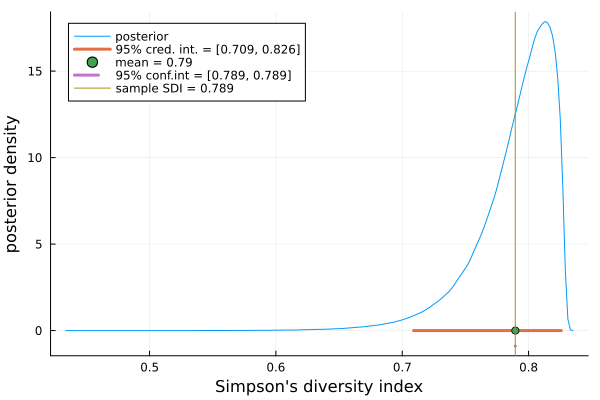

In [4]:
plot_posterior(data = [5, 5, 5, 5])

data = [1, 6]
prior_param = [0, 0]


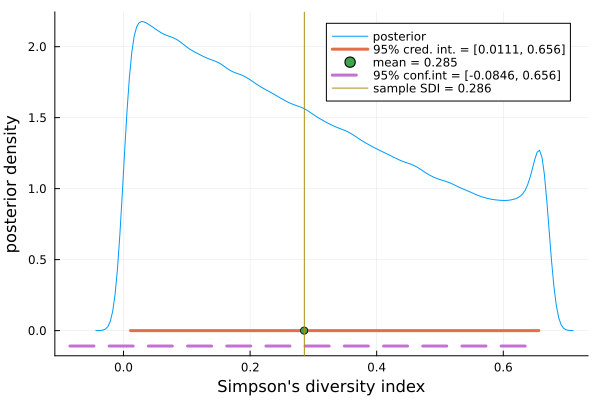

In [5]:
plot_posterior(data = [1, 6])

https://journals.asm.org/doi/10.1128/jcm.39.11.4190-4192.2001

data = [9, 8, 7, 6, 5, 5, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
prior_param = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


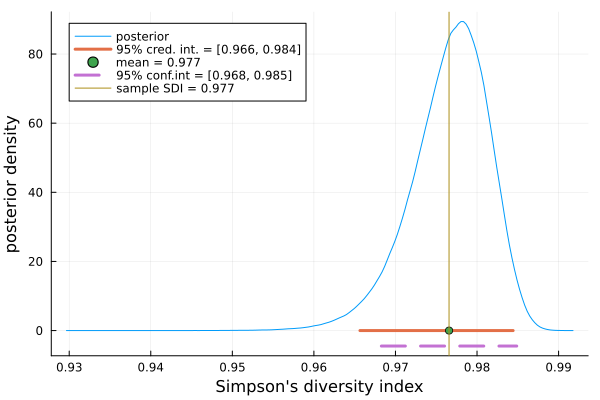

In [6]:
table1 = [9; 8; 7; 6; 5; 5; fill(4, 3); fill(3, 4); fill(2, 9); fill(1, 35)]
plot_posterior(data=table1, legend=:topleft)

data = [37, 5, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
prior_param = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


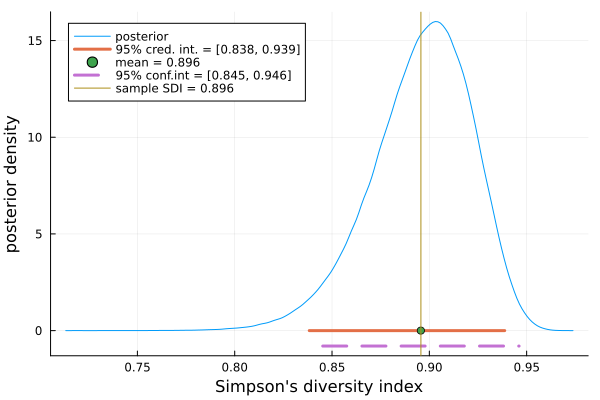

In [7]:
table2 = [37; 5; fill(4, 2); fill(3, 4); fill(2, 8); fill(1, 39)]
plot_posterior(data=table2)

data = [30, 13, 9, 8, 7, 7, 7, 6, 6, 5, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
prior_param = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


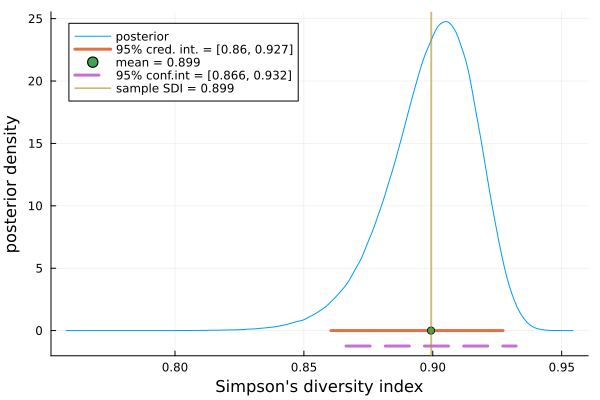

In [8]:
table3 = [30; 13; 9; 8; fill(7, 3); fill(6, 2); 5; fill(2, 3); fill(1, 13)]
plot_posterior(data=table3)

In [9]:
function pvalues_bayes(data, sid₀; κ=eps(), L=10^4)
    m = length(data)
    n = sum(data)
    prior_param = fill(κ, m)
    posterior = Dirichlet(data .+ prior_param)
    Ptmp = rand(posterior)
    c = zeros(Int, length(sid₀))
    d = zeros(Int, length(sid₀))
    for i in 1:L
        P = rand!(posterior, Ptmp)
        sid = sid_bayes(P, n)
        @. c += sid ≤ sid₀
        @. d += sid ≥ sid₀
    end
    @. min(1, 2c/L, 2d/L)
end

function pvalue_bayes(data, sid₀; κ=eps(), L=10^4)
    m = length(data)
    n = sum(data)
    prior_param = fill(κ, m)
    posterior = Dirichlet(data .+ prior_param)
    Ptmp = rand(posterior)
    c = 0
    d = 0
    for i in 1:L
        P = rand!(posterior, Ptmp)
        sid = sid_bayes(P, n)
        c += sid ≤ sid₀
        d += sid ≥ sid₀
    end
    min(1, 2c/L, 2d/L)
end

function sim_pval(dist::Multinomial; niters=10^4, κ=eps(), L=10^4)
    μ = mean(dist)
    sdi₀ = sidhat(μ)
    pval = zeros(niters)
    Ktmp = [rand(dist) for _ in 1:Threads.nthreads()]
    Threads.@threads :static for i in 1:niters
        tid = Threads.threadid()
        K = rand!(dist, Ktmp[tid])
        pval[i] = pvalue_bayes(K, sdi₀; κ, L)
    end
    pval
end

_ecdf(A, x) = count(≤(x), A) / length(A)

_ecdf (generic function with 1 method)

D̂ = sidhat(data) = 0.9765694076038903
length(sid₀) = 100
  1.714245 seconds (1.05 M allocations: 53.553 MiB, 0.70% gc time, 16.71% compilation time)


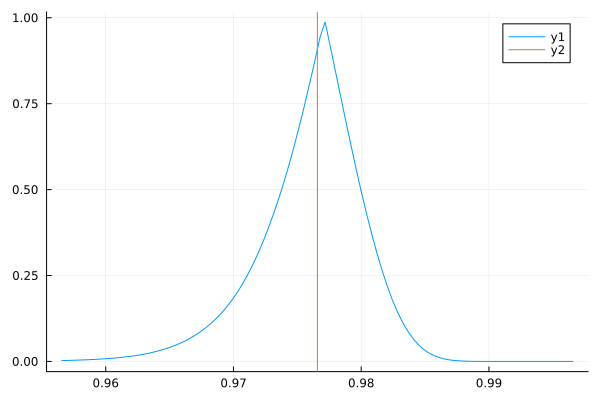

In [10]:
data = table1

@show D̂ = sidhat(data)
sid₀ = range(D̂-0.02, D̂+0.02, 100)
@show length(sid₀)
@time pval = pvalues_bayes(data, sid₀; κ=eps(), L=10^6)
plot(sid₀, pval)
vline!([D̂])

 22.823276 seconds (217.78 k allocations: 23.342 MiB, 0.06% gc time, 5.98% compilation time)


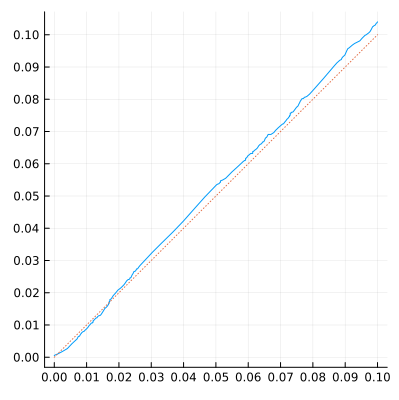

In [11]:
data = table1
dist = Multinomial(sum(data), data/sum(data))
@time pval = sim_pval(dist; κ=0.23, niters=10^4)
plot(α -> _ecdf(pval, α), 0, 0.1; label="")
plot!(identity; label="", ls=:dot)
plot!(xtick=0:0.01:1, ytick=0:0.01:1)
plot!(size=(400, 400))

 23.022492 seconds (60.10 k allocations: 15.197 MiB, 0.06% gc time)


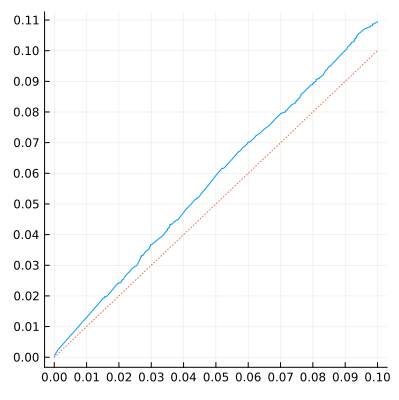

In [12]:
data = table2
dist = Multinomial(sum(data), data/sum(data))
@time pval = sim_pval(dist; κ=0.05, niters=10^4)
plot(α -> _ecdf(pval, α), 0, 0.1; label="")
plot!(identity; label="", ls=:dot)
plot!(xtick=0:0.01:1, ytick=0:0.01:1)
plot!(size=(400, 400))

 13.010936 seconds (60.12 k allocations: 7.870 MiB)


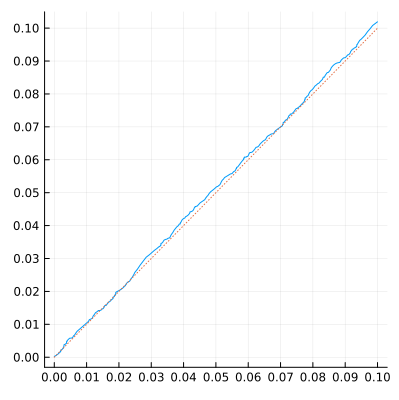

In [13]:
data = table3
dist = Multinomial(sum(data), data/sum(data))
@time pval = sim_pval(dist; κ=0.1, niters=10^4)
plot(α -> _ecdf(pval, α), 0, 0.1; label="")
plot!(identity; label="", ls=:dot)
plot!(xtick=0:0.01:1, ytick=0:0.01:1)
plot!(size=(400, 400))

  1.641966 seconds (60.09 k allocations: 2.832 MiB)


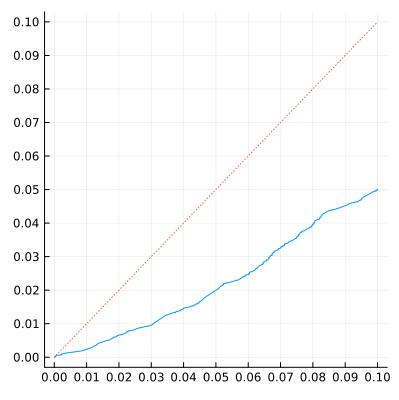

In [16]:
data = [10, 10, 10, 10]
dist = Multinomial(sum(data), data/sum(data))
@time pval = sim_pval(dist; κ=0.1, niters=10^4)
plot(α -> _ecdf(pval, α), 0, 0.1; label="")
plot!(identity; label="", ls=:dot)
plot!(xtick=0:0.01:1, ytick=0:0.01:1)
plot!(size=(400, 400))

  2.707519 seconds (60.10 k allocations: 2.832 MiB)


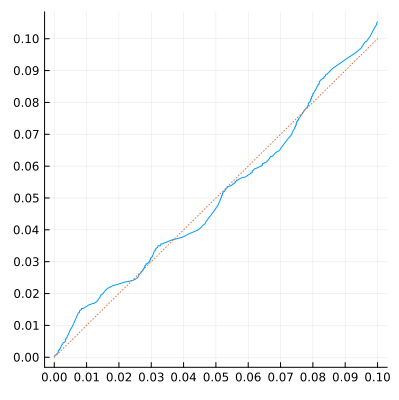

In [15]:
data = [10, 6, 2, 1, 1]
dist = Multinomial(sum(data), data/sum(data))
@time pval = sim_pval(dist; κ=0.1, niters=10^4)
plot(α -> _ecdf(pval, α), 0, 0.1; label="")
plot!(identity; label="", ls=:dot)
plot!(xtick=0:0.01:1, ytick=0:0.01:1)
plot!(size=(400, 400))